# [GD-06] 직접 만들어보는 OCR

## 00. Import

In [1]:
import os
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image, ImageDraw

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128

HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'
TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

## 01. Data

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


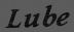

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


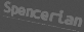

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


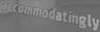

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


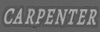

In [3]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [4]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    def _get_img_label(self, index):
        # Return image array and label in string
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

In [5]:
class LabelConverter(object):
     """ Convert between text-label and text-index """

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [6]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## 02. Model

In [7]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [8]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

In [9]:
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

In [11]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=100,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
63/63 [==============================] - 28s 244ms/step - loss: 29.3146 - val_loss: 27.0960

Epoch 00001: val_loss improved from inf to 27.09598, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/100
63/63 [==============================] - 16s 251ms/step - loss: 26.5785 - val_loss: 26.5300

Epoch 00002: val_loss improved from 27.09598 to 26.53004, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/100
63/63 [==============================] - 16s 251ms/step - loss: 26.1581 - val_loss: 26.1148

Epoch 00003: val_loss improved from 26.53004 to 26.11477, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/100
63/63 [==============================] - 16s 241ms/step - loss: 25.8825 - val_loss: 25.9164

Epoch 00004: val_loss improved from 26.11477 to 25.91643, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/100
63/63 [==============================] - 15s 238ms/step - loss: 25.6490 - val_loss: 27.5878

Epoch 00005: val_los


Epoch 00040: val_loss did not improve from 5.31735
Epoch 41/100
63/63 [==============================] - 15s 231ms/step - loss: 5.0691 - val_loss: 5.3449

Epoch 00041: val_loss did not improve from 5.31735
Epoch 42/100
63/63 [==============================] - 15s 229ms/step - loss: 4.7846 - val_loss: 5.1456

Epoch 00042: val_loss improved from 5.31735 to 5.14559, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 43/100
63/63 [==============================] - 15s 231ms/step - loss: 4.8782 - val_loss: 5.0691

Epoch 00043: val_loss improved from 5.14559 to 5.06914, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 44/100
63/63 [==============================] - 15s 229ms/step - loss: 4.7882 - val_loss: 4.8858

Epoch 00044: val_loss improved from 5.06914 to 4.88578, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 45/100
63/63 [==============================] - 15s 233ms/step - loss: 4.8265 - val_loss: 4.9635

Epoch 00045: val_loss did not improve 

Epoch 86/100
63/63 [==============================] - 15s 230ms/step - loss: 3.2256 - val_loss: 3.3432

Epoch 00086: val_loss did not improve from 3.32381
Epoch 87/100
63/63 [==============================] - 15s 230ms/step - loss: 3.2352 - val_loss: 3.3499

Epoch 00087: val_loss did not improve from 3.32381
Epoch 88/100
63/63 [==============================] - 15s 230ms/step - loss: 3.2548 - val_loss: 3.2060

Epoch 00088: val_loss improved from 3.32381 to 3.20596, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 89/100
63/63 [==============================] - 15s 225ms/step - loss: 3.1359 - val_loss: 3.2432

Epoch 00089: val_loss did not improve from 3.20596
Epoch 90/100
63/63 [==============================] - 15s 232ms/step - loss: 3.2487 - val_loss: 3.1831

Epoch 00090: val_loss improved from 3.20596 to 3.18307, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 91/100
63/63 [==============================] - 15s 231ms/step - loss: 3.1539 - val_loss: 3.134

## 03. Results

Result: 	 SLINKING


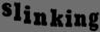

Result: 	 ALEPPO


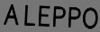

Result: 	 FWANDA


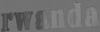

Result: 	 NATHANS


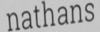

Result: 	 HALLO


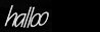

Result: 	 HURLS


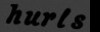

Result: 	 DOWNSIZE


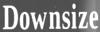

Result: 	 ROBOTIC


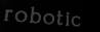

Result: 	 STOPPY


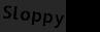

Result: 	 HERMITE


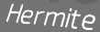

In [35]:
from IPython.display import display

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            if index == -1:
                continue
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

Result: 	 SLINKING


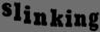

Result: 	 ALEPPO


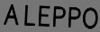

Result: 	 FWANDA


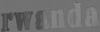

Result: 	 NATHANS


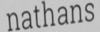

Result: 	 HALLO


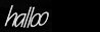

Result: 	 HURLS


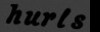

Result: 	 DOWNSIZE


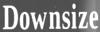

Result: 	 ROBOTIC


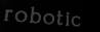

Result: 	 STOPPY


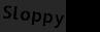

Result: 	 HERMITE


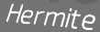

In [36]:
check_inference(model, test_set, index=10)

In [72]:
from keras_ocr.detection import Detector
#SAMPLE_IMG_PATH = 'data/sample.jpg'
SAMPLE_IMG_PATH = os.getenv('HOME')+'/aiffel/ocr_1/sample2.jpeg'
detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [73]:
img = tf.io.read_file(os.path.join(path, SAMPLE_IMG_PATH))
img = tf.image.decode_jpeg(img)
img = tf.image.resize(img , (640, 640))
img = img[tf.newaxis, :, :, :]
det = detector.detect(img.numpy())

In [74]:
o_r = det[0]
print(o_r[0,:,0], o_r[0,:,1])
# o_r

[212.88034 408.0532  405.32944 210.15659] [185.11078 192.61743 263.43576 255.92911]


In [75]:
ori_o_r = o_r.copy()
for c in range(len(ori_o_r)):
    print(c)

0
1


In [76]:
o_r = ori_o_r.copy()
tmp = o_r[0,:,0].copy()
# print(o_r[0])
o_r[0,:,0] = o_r[0,:,1]
# print(o_r[0])
o_r[0,:,1] = tmp
# print(o_r[0])
o_r[0]

array([[185.11078, 212.88034],
       [192.61743, 408.0532 ],
       [263.43576, 405.32944],
       [255.92911, 210.15659]], dtype=float32)

In [77]:
img_draw = ImageDraw.Draw

In [78]:
def detect_text(img_path):
    # TODO
    # 이미지 불러오기
    img_pil = Image.open(img_path)
    img_pil = img_pil.resize((640, 640))
    img_draw=ImageDraw.Draw(img_pil)
    result_img = img_pil
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (640, 640))
    img = img[tf.newaxis, :, :, :]
        # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    det_result = detector.detect(img.numpy())
        # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = det_result[0]
        # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
#     for idx in range(len(ocr_result)) :
#         tmp = ocr_result[idx, :, 0].copy()
#         ocr_result[idx, :, 0] = ocr_result[idx, :, 1]
#         ocr_result[idx, :, 1] = tmp
        
        
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

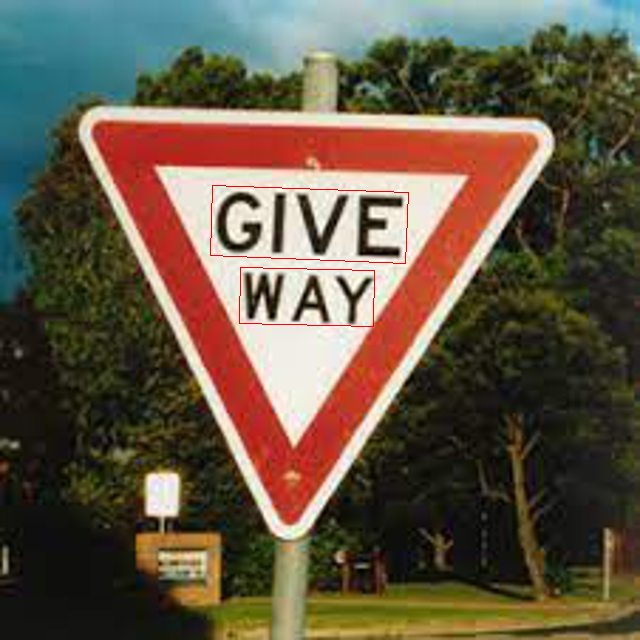

In [79]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

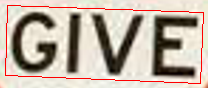

In [80]:
cropped_img[0]


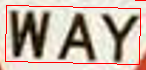

In [81]:
cropped_img[1]

In [82]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred.predict(np_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))

Result: 	 GIVE


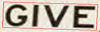

Result: 	 WAY


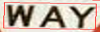

In [83]:
for _img in cropped_img:
    recognize_img(_img)

## 04. 회고

1. 모델의 정확성
- 크기가 균일하고 길지 않는 경우 글자를 잘 인식하였지만, 글자의 크기가 다르고 길어질 경우 정확도가 내려갔다.
- 깔끔한 dataset 특히 책같이 글자가 균일한 경우 쓰기가 편했다.

2. cnn + rnn
- 두개의 모델을 같이 쓰게된다는 아이디어가 신선했다. 결국에는 둘다 배워야한다는 생각이 들었다. 더 자세히 공부해보고 싶다는 생각이 들었다.